In [5]:

import pandas as pd
print(pd.read_csv("household_power_consumption_daily.csv").columns)

Index(['DateTime', 'Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'Month', 'DayOfWeek', 'Hour', 'Season'],
      dtype='object')


MA(12) — MAE: 0.73, RMSE: 1.09
date
2008-09-15 17:00:00    0.491636
2008-09-16 17:00:00    0.511589
2008-09-17 17:00:00    0.535060
2008-09-18 17:00:00    0.558054
2008-09-19 17:00:00    0.554626
Freq: D, dtype: float64


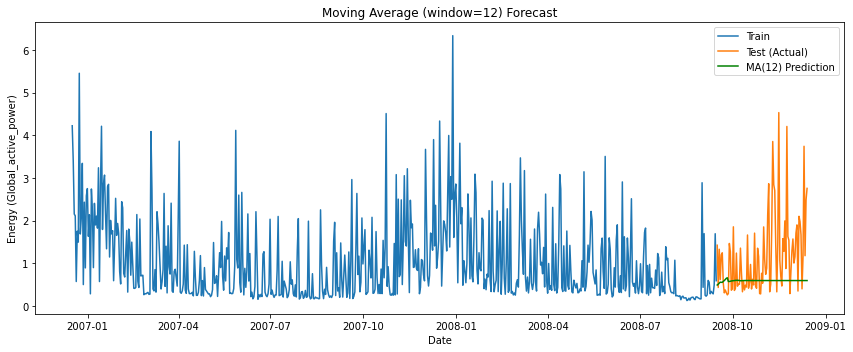

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load your cleaned daily file
daily = pd.read_csv("household_power_consumption_hourly.csv")

# Parse DateTime
daily["DateTime"] = pd.to_datetime(daily["DateTime"])

# Sort and rename
daily = daily.sort_values("DateTime")
daily = daily.rename(columns={"DateTime": "date"})

# Extract energy column
y = daily.set_index("date")["Global_active_power"]

# Ensure daily frequency
y = y.asfreq("D")

# Fill missing values to avoid NaNs during evaluation
y = y.interpolate(limit_direction="both")

# Split: last 90 days = test
h = 90
train = y.iloc[:-h].copy()
test = y.iloc[-h:].copy()

# Moving Average window
window = 7
ma_pred = []

# Rolling forecast
hist = train.copy()
for t in test.index:
    # If not enough history, adjust window
    effective_window = min(window, len(hist))
    pred = hist.iloc[-effective_window:].mean()
    ma_pred.append(pred)
    hist = pd.concat([hist, pd.Series(pred, index=[t])])  # use pred, not NaN!

# Convert predictions to Series
ma_pred = pd.Series(ma_pred, index=test.index)

# FINAL SAFETY CHECK: remove any NaNs
mask = ~(test.isna() | ma_pred.isna())
test_clean = test[mask]
pred_clean = ma_pred[mask]

# Evaluate
mae = mean_absolute_error(test_clean, pred_clean)
rmse = np.sqrt(mean_squared_error(test_clean, pred_clean))
print(f"MA({window}) — MAE: {mae:.2f}, RMSE: {rmse:.2f}")

print(ma_pred.head())

# Plot
plt.figure(figsize=(12,5))
plt.plot(train.index, train.values, label="Train")
plt.plot(test.index, test.values, label="Test (Actual)")
plt.plot(test.index, ma_pred.values, label=f"MA({window}) Prediction", color="green")
plt.title(f"Moving Average (window={window}) Forecast")
plt.xlabel("Date")
plt.ylabel("Energy (Global_active_power)")
plt.legend()
plt.tight_layout()
plt.show()




